# 🎯 Preparación de Dataset SVDD para Entrenamiento

## Objetivo
Extraer, convertir y balancear archivos de audio vocal `/a/` del dataset SVDD (ZIP anidado) hacia una estructura organizada Healthy/Pathological en formato `.wav` para entrenamiento de CNN.

## Proceso
1. **Exploración**: Analizar estructura del ZIP anidado
2. **Extracción**: Filtrar solo vocales `/a/` (archivos con `-a_` o `-a.` en nombre)
3. **Conversión**: Transformar `.NSP` → `.wav` (44.1 kHz mono)
4. **Balanceo**: Distribuir uniformemente entre Healthy y Pathological
5. **Organización**: Estructura final `/data/svdd_processed/`
6. **Validación**: Verificar integridad y generar reportes

---


In [ ]:
# ============================================================================
# 1. CONFIGURACIÓN Y DEPENDENCIAS
# ============================================================================

import zipfile
import os
import shutil
import re
import random
import json
import io
from pathlib import Path
from typing import List, Dict, Tuple, Optional
import warnings
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading
warnings.filterwarnings('ignore')

# Análisis de datos
import pandas as pd
import numpy as np

# Audio processing
import soundfile as sf
import librosa

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Configuración de matplotlib
plt.style.use('default')
sns.set_palette("husl")

print("Librerías importadas correctamente")
print(f"Directorio de trabajo: {os.getcwd()}")

# ============================================================================
# CONFIGURACIÓN DE PARÁMETROS
# ============================================================================

# Rutas
ZIP_PATH = r"C:\Users\fecor\Downloads\16874898.zip"
TEMP_DIR = Path("./temp/svdd_extraction")
OUTPUT_DIR = Path("../data/svdd_processed")
HEALTHY_DIR = OUTPUT_DIR / "healthy"
PATHOLOGICAL_DIR = OUTPUT_DIR / "pathological"

# Crear directorios necesarios
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

# Parámetros de audio
TARGET_SAMPLE_RATE = 44100
VOWEL_PATTERN = r'-a[._]'  # Patrón para vocal /a/
SEED = 42

# Archivos de estado para resumir proceso
STATE_FILE = Path("./temp/svdd_state.json")
EXTRACTED_DF_FILE = Path("./temp/extracted_df.pkl")
CONVERSION_DF_FILE = Path("./temp/conversion_df.pkl")
BALANCED_DF_FILE = Path("./temp/balanced_df.pkl")
METADATA_FILE = OUTPUT_DIR / "metadata.json"

# Configurar seeds para reproducibilidad
random.seed(SEED)
np.random.seed(SEED)

print(f"ZIP origen: {ZIP_PATH}")
print(f"Directorio temporal: {TEMP_DIR}")
print(f"Directorio salida: {OUTPUT_DIR}")
print(f"Sample rate objetivo: {TARGET_SAMPLE_RATE} Hz")
print(f"Patrón vocal /a/: {VOWEL_PATTERN}")
print(f"Seed: {SEED}")

# ============================================================================
# FUNCIONES DE ESTADO PARA PROCESO RESUMIBLE
# ============================================================================

def save_state(step: str, data: Dict = None):
    """
    Guarda el estado actual del proceso.
    
    Args:
        step: Paso actual del proceso
        data: Datos adicionales a guardar
    """
    state = {
        'current_step': step,
        'timestamp': pd.Timestamp.now().isoformat(),
        'zip_path': ZIP_PATH,
        'output_dir': str(OUTPUT_DIR),
        'data': data or {}
    }
    
    # Crear directorio temporal si no existe
    TEMP_DIR.mkdir(parents=True, exist_ok=True)
    
    with open(STATE_FILE, 'w', encoding='utf-8') as f:
        json.dump(state, f, indent=2, ensure_ascii=False)
    
    print(f"Estado guardado: {step}")

def load_state() -> Optional[Dict]:
    """
    Carga el estado previo del proceso.
    
    Returns:
        Estado previo o None si no existe
    """
    if STATE_FILE.exists():
        try:
            with open(STATE_FILE, 'r', encoding='utf-8') as f:
                state = json.load(f)
            print(f"Estado previo encontrado: {state.get('current_step', 'desconocido')}")
            return state
        except Exception as e:
            print(f"Error cargando estado: {e}")
            return None
    return None

def save_dataframe(df: pd.DataFrame, file_path: Path):
    """
    Guarda DataFrame en archivo pickle.
    
    Args:
        df: DataFrame a guardar
        file_path: Ruta del archivo
    """
    if not df.empty:
        df.to_pickle(file_path)
        print(f"DataFrame guardado: {file_path}")

def load_dataframe(file_path: Path) -> pd.DataFrame:
    """
    Carga DataFrame desde archivo pickle.
    
    Args:
        file_path: Ruta del archivo
        
    Returns:
        DataFrame cargado o DataFrame vacío
    """
    if file_path.exists():
        try:
            df = pd.read_pickle(file_path)
            print(f"DataFrame cargado: {file_path} ({len(df)} filas)")
            return df
        except Exception as e:
            print(f"Error cargando DataFrame: {e}")
            return pd.DataFrame()
    return pd.DataFrame()

def check_step_completed(step: str) -> bool:
    """
    Verifica si un paso ya fue completado.
    
    Args:
        step: Nombre del paso
        
    Returns:
        True si el paso está completado
    """
    state = load_state()
    if state and state.get('current_step') == step:
        return True
    
    # Verificaciones específicas por paso
    if step == 'extraction':
        return not extracted_df.empty if 'extracted_df' in globals() else False
    elif step == 'conversion':
        return not conversion_df.empty if 'conversion_df' in globals() else False
    elif step == 'balancing':
        return not balanced_df.empty if 'balanced_df' in globals() else False
    elif step == 'organization':
        return OUTPUT_DIR.exists() and (HEALTHY_DIR.exists() or PATHOLOGICAL_DIR.exists())
    elif step == 'validation':
        return METADATA_FILE.exists()
    
    return False

# Inicializar variables globales
extracted_df = pd.DataFrame()
conversion_df = pd.DataFrame()
balanced_df = pd.DataFrame()
final_metadata = {}
validation_results = {}

# Intentar cargar estado previo
print("\nVerificando estado previo del proceso...")
prev_state = load_state()

if prev_state:
    print(f"Proceso previo encontrado en paso: {prev_state.get('current_step', 'desconocido')}")
    print(f"Timestamp: {prev_state.get('timestamp', 'desconocido')}")
    
    # Preguntar si continuar
    print("\n¿Desea continuar desde donde se quedó? (y/n)")
    continue_process = input("Continuar proceso previo? [y/n]: ").lower().strip()
    
    if continue_process == 'y':
        print("Continuando proceso previo...")
        # Cargar DataFrames guardados
        extracted_df = load_dataframe(EXTRACTED_DF_FILE)
        conversion_df = load_dataframe(CONVERSION_DF_FILE)
        balanced_df = load_dataframe(BALANCED_DF_FILE)
        
        # Cargar metadata si existe
        if METADATA_FILE.exists():
            try:
                with open(METADATA_FILE, 'r', encoding='utf-8') as f:
                    final_metadata = json.load(f)
                print("Metadata previa cargada")
            except:
                pass
    else:
        print("Iniciando proceso desde el principio...")
        # Limpiar archivos de estado
        for file in [STATE_FILE, EXTRACTED_DF_FILE, CONVERSION_DF_FILE, BALANCED_DF_FILE]:
            if file.exists():
                file.unlink()
else:
    print("No se encontró proceso previo. Iniciando desde el principio...")


Librerías importadas correctamente
Directorio de trabajo: C:\Proyectos\PHD- Parkinson - Incertidumbre - Prototipo\parkinson-voice-uncertainty\notebooks
ZIP origen: C:\Users\fecor\Downloads\16874898.zip
Directorio temporal: temp\svdd_extraction
Directorio salida: data\svdd_processed
Sample rate objetivo: 44100 Hz
Patrón vocal /a/: -a[._]
Seed: 42

Verificando estado previo del proceso...
Estado previo encontrado: exploration
Proceso previo encontrado en paso: exploration
Timestamp: 2025-10-23T18:39:33.342374

¿Desea continuar desde donde se quedó? (y/n)


Continuar proceso previo? [y/n]:  n


Iniciando proceso desde el principio...


Continuando proceso previo...


Iniciando proceso desde el principio...


In [5]:
# ============================================================================
# 2. EXPLORACIÓN DE ESTRUCTURA ZIP
# ============================================================================

def process_small_zip(main_zip, nested_zip_name, stats_lock, stats):
    """
    Procesa un ZIP pequeño en memoria.
    
    Args:
        main_zip: ZIP principal abierto
        nested_zip_name: Nombre del ZIP anidado
        stats_lock: Lock para acceso thread-safe a stats
        stats: Diccionario de estadísticas compartido
    """
    try:
        # Leer ZIP anidado
        nested_zip_data = main_zip.read(nested_zip_name)
        
        with zipfile.ZipFile(io.BytesIO(nested_zip_data), 'r') as nested_zip:
            file_list = nested_zip.namelist()
            nsp_files = [f for f in file_list if f.endswith('.nsp')]
            
            print(f"     [PEQUEÑO] {nested_zip_name}: {len(nsp_files)} archivos .NSP")
            
            # Procesar archivos .NSP
            local_stats = {
                'total_files': 0,
                'nsp_files': 0,
                'vowel_a_files': 0,
                'pathologies': {},
                'healthy_files': 0
            }
            
            for j, file_info in enumerate(nsp_files):
                local_stats['total_files'] += 1
                local_stats['nsp_files'] += 1
                
                # Verificar si es vocal /a/
                if re.search(VOWEL_PATTERN, file_info):
                    local_stats['vowel_a_files'] += 1
                    
                    # Determinar patología
                    pathology_name = nested_zip_name.replace('.zip', '')
                    local_stats['pathologies'][pathology_name] = local_stats['pathologies'].get(pathology_name, 0) + 1
                    
                    # Identificar archivos healthy
                    if 'healthy' in pathology_name.lower():
                        local_stats['healthy_files'] += 1
                
                # Límite para ZIPs pequeños
                if j > 1000:
                    break
            
            # Actualizar estadísticas globales de forma thread-safe
            with stats_lock:
                stats['total_files'] += local_stats['total_files']
                stats['nsp_files'] += local_stats['nsp_files']
                stats['vowel_a_files'] += local_stats['vowel_a_files']
                stats['healthy_files'] += local_stats['healthy_files']
                
                for pathology, count in local_stats['pathologies'].items():
                    stats['pathologies'][pathology] = stats['pathologies'].get(pathology, 0) + count
                
                print(f"     [PEQUEÑO] {nested_zip_name} completado: {local_stats['vowel_a_files']} vocales /a/")
    
    except Exception as e:
        print(f"     [PEQUEÑO] Error en {nested_zip_name}: {e}")

def process_large_zip(main_zip, nested_zip_name, temp_dir, stats_lock, stats):
    """
    Procesa un ZIP grande extrayéndolo a disco.
    
    Args:
        main_zip: ZIP principal abierto
        nested_zip_name: Nombre del ZIP anidado
        temp_dir: Directorio temporal
        stats_lock: Lock para acceso thread-safe a stats
        stats: Diccionario de estadísticas compartido
    """
    temp_zip_dir = None
    try:
        # Crear directorio temporal
        temp_zip_dir = temp_dir / f"temp_{nested_zip_name.replace('.zip', '')}"
        temp_zip_dir.mkdir(parents=True, exist_ok=True)
        
        # Extraer ZIP a disco
        main_zip.extract(nested_zip_name, temp_zip_dir)
        extracted_zip_path = temp_zip_dir / nested_zip_name
        
        with zipfile.ZipFile(extracted_zip_path, 'r') as nested_zip:
            file_list = nested_zip.namelist()
            nsp_files = [f for f in file_list if f.endswith('.nsp')]
            
            print(f"     [GRANDE] {nested_zip_name}: {len(nsp_files)} archivos .NSP")
            
            # Procesar archivos .NSP
            local_stats = {
                'total_files': 0,
                'nsp_files': 0,
                'vowel_a_files': 0,
                'pathologies': {},
                'healthy_files': 0
            }
            
            for j, file_info in enumerate(nsp_files):
                local_stats['total_files'] += 1
                local_stats['nsp_files'] += 1
                
                # Verificar si es vocal /a/
                if re.search(VOWEL_PATTERN, file_info):
                    local_stats['vowel_a_files'] += 1
                    
                    # Determinar patología
                    pathology_name = nested_zip_name.replace('.zip', '')
                    local_stats['pathologies'][pathology_name] = local_stats['pathologies'].get(pathology_name, 0) + 1
                    
                    # Identificar archivos healthy
                    if 'healthy' in pathology_name.lower():
                        local_stats['healthy_files'] += 1
                
                # Límite para ZIPs grandes
                if j > 2000:
                    break
            
            # Actualizar estadísticas globales de forma thread-safe
            with stats_lock:
                stats['total_files'] += local_stats['total_files']
                stats['nsp_files'] += local_stats['nsp_files']
                stats['vowel_a_files'] += local_stats['vowel_a_files']
                stats['healthy_files'] += local_stats['healthy_files']
                
                for pathology, count in local_stats['pathologies'].items():
                    stats['pathologies'][pathology] = stats['pathologies'].get(pathology, 0) + count
                
                print(f"     [GRANDE] {nested_zip_name} completado: {local_stats['vowel_a_files']} vocales /a/")
    
    except Exception as e:
        print(f"     [GRANDE] Error en {nested_zip_name}: {e}")
    
    finally:
        # Limpiar archivos temporales
        if temp_zip_dir and temp_zip_dir.exists():
            shutil.rmtree(temp_zip_dir, ignore_errors=True)

def explore_zip_structure(zip_path: str, max_depth: int = 3) -> Dict:
    """
    Explora la estructura del ZIP anidado y cuenta archivos .NSP por categoría.
    Maneja ZIPs anidados como healthy.zip, Diplophonie.zip, etc.
    
    Args:
        zip_path: Ruta al archivo ZIP principal
        max_depth: Profundidad máxima de exploración
        
    Returns:
        Diccionario con estadísticas de la estructura
    """
    print(f"[PASO 1/8] Explorando estructura del ZIP: {zip_path}")
    
    stats = {
        'total_files': 0,
        'nsp_files': 0,
        'vowel_a_files': 0,
        'pathologies': {},
        'healthy_files': 0,
        'structure': [],
        'nested_zips': []
    }
    
    try:
        with zipfile.ZipFile(zip_path, 'r') as main_zip:
            print(f"ZIP principal abierto: {len(main_zip.namelist())} archivos")
            
            # Primero identificar ZIPs anidados
            nested_zip_files = [f for f in main_zip.namelist() if f.endswith('.zip')]
            print(f"ZIPs anidados encontrados: {len(nested_zip_files)}")
            
            # Mostrar lista de ZIPs para referencia
            print("ZIPs encontrados:")
            for i, zip_name in enumerate(nested_zip_files[:10]):  # Mostrar solo los primeros 10
                print(f"   {i+1}. {zip_name}")
            if len(nested_zip_files) > 10:
                print(f"   ... y {len(nested_zip_files) - 10} más")
            
            # Filtrar solo data.zip problemático, procesar todos los demás
            filtered_zips = []
            
            for nested_zip_name in nested_zip_files:
                # Saltar solo data.zip problemático
                if nested_zip_name.lower() == 'data.zip':
                    print(f"   Saltando {nested_zip_name} (ZIP problemático)")
                    continue
                
                # Procesar todos los demás ZIPs
                zip_info = main_zip.getinfo(nested_zip_name)
                zip_size_mb = zip_info.file_size / (1024*1024)
                filtered_zips.append((nested_zip_name, zip_size_mb))
            
            print(f"ZIPs a procesar: {len(filtered_zips)}")
            
            # Separar ZIPs grandes y pequeños
            small_zips = [(name, size) for name, size in filtered_zips if size <= 50]
            large_zips = [(name, size) for name, size in filtered_zips if size > 50]
            
            print(f"ZIPs pequeños: {len(small_zips)}")
            print(f"ZIPs grandes: {len(large_zips)}")
            
            # Crear lock para acceso thread-safe a estadísticas
            stats_lock = threading.Lock()
            
            # Procesar en paralelo
            with ThreadPoolExecutor(max_workers=4) as executor:
                futures = []
                
                # Procesar ZIPs pequeños (2 hilos)
                for nested_zip_name, zip_size_mb in small_zips:
                    print(f"   [PEQUEÑO] Enviando {nested_zip_name} ({zip_size_mb:.1f} MB) a hilo")
                    future = executor.submit(process_small_zip, main_zip, nested_zip_name, stats_lock, stats)
                    futures.append(('small', future))
                
                # Procesar ZIPs grandes (2 hilos)
                for nested_zip_name, zip_size_mb in large_zips:
                    print(f"   [GRANDE] Enviando {nested_zip_name} ({zip_size_mb:.1f} MB) a hilo")
                    future = executor.submit(process_large_zip, main_zip, nested_zip_name, TEMP_DIR, stats_lock, stats)
                    futures.append(('large', future))
                
                # Esperar a que terminen todos los hilos
                print(f"\nProcesando {len(futures)} ZIPs en paralelo...")
                completed = 0
                
                for zip_type, future in futures:
                    try:
                        future.result()  # Esperar a que termine
                        completed += 1
                        print(f"   Completado {completed}/{len(futures)}: {zip_type}")
                    except Exception as e:
                        print(f"   Error en hilo {zip_type}: {e}")
                
                print(f"Procesamiento paralelo completado: {completed}/{len(futures)} ZIPs procesados")
    
    except Exception as e:
        print(f"Error explorando ZIP: {e}")
        return None
    
    # Mostrar resumen
    print(f"\nRESUMEN DE EXPLORACIÓN:")
    print(f"   Total archivos: {stats['total_files']}")
    print(f"   Archivos .NSP: {stats['nsp_files']}")
    print(f"   Vocales /a/: {stats['vowel_a_files']}")
    print(f"   Archivos healthy: {stats['healthy_files']}")
    print(f"   Patologías encontradas: {len(stats['pathologies'])}")
    
    return stats

# Ejecutar exploración solo si no está completada
if not check_step_completed('exploration'):
    print("\nIniciando exploración del ZIP...")
    zip_stats = explore_zip_structure(ZIP_PATH)
    
    if zip_stats:
        print(f"\nPATOLOGÍAS DETECTADAS:")
        for pathology, count in zip_stats['pathologies'].items():
            print(f"   {pathology}: {count} archivos vocal /a/")
        
        # Guardar estado
        save_state('exploration', {'zip_stats': zip_stats})
    else:
        print("No se pudo explorar el ZIP. Verificar ruta y formato.")
        zip_stats = None
else:
    print("Exploración ya completada. Saltando paso...")
    zip_stats = {'pathologies': {}, 'vowel_a_files': 0, 'healthy_files': 0}



Iniciando exploración del ZIP...
[PASO 1/8] Explorando estructura del ZIP: C:\Users\fecor\Downloads\16874898.zip
ZIP principal abierto: 73 archivos
ZIPs anidados encontrados: 73
ZIPs encontrados:
   1. Cyste.zip
   2. Poltersyndrom.zip
   3. Sängerstimme.zip
   4. Frontolaterale Teilresektion.zip
   5. Morbus Parkinson.zip
   6. Kehlkopftumor.zip
   7. Sigmatismus.zip
   8. Reinke Ödem.zip
   9. Granulom.zip
   10. Morbus Down.zip
   ... y 63 más
   Saltando data.zip (ZIP problemático)
ZIPs a procesar: 72
ZIPs pequeños: 43
ZIPs grandes: 29
   [PEQUEÑO] Enviando Cyste.zip (35.4 MB) a hilo
   [PEQUEÑO] Enviando Poltersyndrom.zip (21.6 MB) a hilo
   [PEQUEÑO] Enviando Sängerstimme.zip (22.5 MB) a hilo
   [PEQUEÑO] Enviando Morbus Parkinson.zip (5.3 MB) a hilo
   [PEQUEÑO] Enviando Kehlkopftumor.zip (34.5 MB) a hilo
   [PEQUEÑO] Enviando Sigmatismus.zip (35.0 MB) a hilo
   [PEQUEÑO] Enviando Granulom.zip (16.1 MB) a hilo
   [PEQUEÑO] Enviando Morbus Down.zip (8.6 MB) a hilo
   [PEQUEÑO

In [6]:
# ============================================================================
# 3. EXTRACCIÓN Y FILTRADO DE ARCHIVOS VOCAL /a/
# ============================================================================

def extract_vowel_a_files(zip_path: str, temp_dir: Path) -> pd.DataFrame:
    """
    Extrae archivos .NSP con vocal /a/ del ZIP anidado.
    Maneja ZIPs anidados como healthy.zip, Diplophonie.zip, etc.
    
    Args:
        zip_path: Ruta al ZIP principal
        temp_dir: Directorio temporal para extracción
        
    Returns:
        DataFrame con información de archivos extraídos
    """
    print(f"[PASO 2/8] Extrayendo archivos vocal /a/...")
    
    # Crear directorio temporal
    temp_dir.mkdir(parents=True, exist_ok=True)
    
    extracted_files = []
    
    try:
        with zipfile.ZipFile(zip_path, 'r') as main_zip:
            # Identificar ZIPs anidados
            nested_zip_files = [f for f in main_zip.namelist() if f.endswith('.zip')]
            print(f"ZIPs anidados encontrados: {len(nested_zip_files)}")
            
            # Filtrar solo data.zip problemático, procesar todos los demás
            filtered_zips = []
            
            for nested_zip_name in nested_zip_files:
                # Saltar solo data.zip problemático
                if nested_zip_name.lower() == 'data.zip':
                    print(f"Saltando {nested_zip_name} (ZIP problemático)")
                    continue
                
                # Procesar todos los demás ZIPs
                filtered_zips.append(nested_zip_name)
            
            print(f"ZIPs a procesar: {len(filtered_zips)}")
            
            for nested_zip_name in filtered_zips:
                print(f"Procesando ZIP anidado: {nested_zip_name}")
                
                try:
                    # Extraer ZIP anidado temporalmente
                    nested_zip_data = main_zip.read(nested_zip_name)
                    
                    with zipfile.ZipFile(io.BytesIO(nested_zip_data), 'r') as nested_zip:
                        # Filtrar archivos vocal /a/ en el ZIP anidado
                        vowel_a_files = [f for f in nested_zip.namelist() 
                                       if f.endswith('.nsp') and re.search(VOWEL_PATTERN, f)]
                        
                        print(f"   Encontrados {len(vowel_a_files)} archivos vocal /a/ en {nested_zip_name}")
                        
                        # Extraer archivos del ZIP anidado
                        for file_path in tqdm(vowel_a_files, desc=f"Extrayendo de {nested_zip_name}"):
                            try:
                                # Crear ruta de destino
                                pathology_name = nested_zip_name.replace('.zip', '')
                                dest_path = temp_dir / pathology_name / file_path
                                dest_path.parent.mkdir(parents=True, exist_ok=True)
                                
                                # Extraer archivo del ZIP anidado
                                with nested_zip.open(file_path) as source_file:
                                    with open(dest_path, 'wb') as target_file:
                                        target_file.write(source_file.read())
                                
                                # Obtener información del archivo
                                file_info = nested_zip.getinfo(file_path)
                                file_size = file_info.file_size
                                
                                # Determinar categoría
                                is_healthy = 'healthy' in pathology_name.lower()
                                
                                # Agregar a lista
                                extracted_files.append({
                                    'filename': os.path.basename(file_path),
                                    'original_path': f"{nested_zip_name}/{file_path}",
                                    'extracted_path': str(dest_path),
                                    'pathology': pathology_name,
                                    'is_healthy': is_healthy,
                                    'size_bytes': file_size,
                                    'category': 'healthy' if is_healthy else 'pathological'
                                })
                                
                            except Exception as e:
                                print(f"Error extrayendo {file_path} de {nested_zip_name}: {e}")
                                continue
                
                except Exception as e:
                    print(f"Error procesando {nested_zip_name}: {e}")
                    continue
    
    except Exception as e:
        print(f"Error en extracción: {e}")
        return pd.DataFrame()
    
    # Crear DataFrame
    df = pd.DataFrame(extracted_files)
    
    if not df.empty:
        print(f"\nARCHIVOS EXTRAÍDOS:")
        print(f"   Total: {len(df)}")
        print(f"   Healthy: {len(df[df['is_healthy']])}")
        print(f"   Pathological: {len(df[~df['is_healthy']])}")
        print(f"   Tamaño total: {df['size_bytes'].sum() / (1024*1024):.1f} MB")
        
        # Mostrar distribución por patología
        pathology_counts = df['pathology'].value_counts()
        print(f"\nDISTRIBUCIÓN POR PATOLOGÍA:")
        for pathology, count in pathology_counts.items():
            print(f"   {pathology}: {count} archivos")
    
    return df

# Ejecutar extracción solo si no está completada
if not check_step_completed('extraction'):
    if zip_stats:
        print(f"\nIniciando extracción...")
        extracted_df = extract_vowel_a_files(ZIP_PATH, TEMP_DIR)
        
        if not extracted_df.empty:
            print(f"\nExtracción completada exitosamente")
            print(f"Archivos extraídos en: {TEMP_DIR}")
            
            # Guardar DataFrame y estado
            save_dataframe(extracted_df, EXTRACTED_DF_FILE)
            save_state('extraction')
        else:
            print(f"No se pudieron extraer archivos")
            extracted_df = pd.DataFrame()
    else:
        print(f"No se puede proceder sin exploración previa")
        extracted_df = pd.DataFrame()
else:
    print("Extracción ya completada. Saltando paso...")
    extracted_df = load_dataframe(EXTRACTED_DF_FILE)


Estado previo encontrado: exploration

Iniciando extracción...
[PASO 2/8] Extrayendo archivos vocal /a/...
ZIPs anidados encontrados: 73
Saltando data.zip (ZIP problemático)
ZIPs a procesar: 72
Procesando ZIP anidado: Cyste.zip
   Encontrados 24 archivos vocal /a/ en Cyste.zip


Extrayendo de Cyste.zip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 431.89it/s]

Procesando ZIP anidado: Poltersyndrom.zip


   Encontrados 12 archivos vocal /a/ en Poltersyndrom.zip


Extrayendo de Poltersyndrom.zip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 307.69it/s]


Procesando ZIP anidado: Sängerstimme.zip
   Encontrados 8 archivos vocal /a/ en Sängerstimme.zip


Extrayendo de Sängerstimme.zip: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 275.86it/s]


Procesando ZIP anidado: Frontolaterale Teilresektion.zip
   Encontrados 140 archivos vocal /a/ en Frontolaterale Teilresektion.zip


Extrayendo de Frontolaterale Teilresektion.zip: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [00:00<00:00, 383.41it/s]


Procesando ZIP anidado: Morbus Parkinson.zip
   Encontrados 4 archivos vocal /a/ en Morbus Parkinson.zip


Extrayendo de Morbus Parkinson.zip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 78.43it/s]


Procesando ZIP anidado: Kehlkopftumor.zip
   Encontrados 20 archivos vocal /a/ en Kehlkopftumor.zip


Extrayendo de Kehlkopftumor.zip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 453.98it/s]

Procesando ZIP anidado: Sigmatismus.zip


   Encontrados 16 archivos vocal /a/ en Sigmatismus.zip


Extrayendo de Sigmatismus.zip: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 362.18it/s]


Procesando ZIP anidado: Reinke Ödem.zip
   Encontrados 272 archivos vocal /a/ en Reinke Ödem.zip


Extrayendo de Reinke Ödem.zip: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 272/272 [00:00<00:00, 372.73it/s]


Procesando ZIP anidado: Granulom.zip
   Encontrados 8 archivos vocal /a/ en Granulom.zip


Extrayendo de Granulom.zip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 77.68it/s]


Procesando ZIP anidado: Morbus Down.zip
   Encontrados 4 archivos vocal /a/ en Morbus Down.zip


Extrayendo de Morbus Down.zip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 363.60it/s]

Procesando ZIP anidado: Dysarthrophonie.zip


   Encontrados 76 archivos vocal /a/ en Dysarthrophonie.zip


Extrayendo de Dysarthrophonie.zip: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 412.51it/s]


Procesando ZIP anidado: Epiglottiskarzinom.zip
   Encontrados 4 archivos vocal /a/ en Epiglottiskarzinom.zip


Extrayendo de Epiglottiskarzinom.zip: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 188.94it/s]


Procesando ZIP anidado: Mediale Halscyste.zip
   Encontrados 4 archivos vocal /a/ en Mediale Halscyste.zip


Extrayendo de Mediale Halscyste.zip: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 333.17it/s]


Procesando ZIP anidado: Intubationsschaden.zip
   Encontrados 12 archivos vocal /a/ en Intubationsschaden.zip


Extrayendo de Intubationsschaden.zip: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 360.82it/s]


Procesando ZIP anidado: Rhinophonie clausa.zip
   Encontrados 4 archivos vocal /a/ en Rhinophonie clausa.zip


Extrayendo de Rhinophonie clausa.zip: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 266.64it/s]

Procesando ZIP anidado: Synechie.zip


   Encontrados 8 archivos vocal /a/ en Synechie.zip


Extrayendo de Synechie.zip: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 281.88it/s]


Procesando ZIP anidado: Taschenfaltenhyperplasie.zip
   Encontrados 8 archivos vocal /a/ en Taschenfaltenhyperplasie.zip


Extrayendo de Taschenfaltenhyperplasie.zip: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 266.28it/s]


Procesando ZIP anidado: Stimmlippenpolyp.zip
   Encontrados 180 archivos vocal /a/ en Stimmlippenpolyp.zip


Extrayendo de Stimmlippenpolyp.zip: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 393.61it/s]


Procesando ZIP anidado: Psychogene Mikrophonie.zip
   Encontrados 4 archivos vocal /a/ en Psychogene Mikrophonie.zip


Extrayendo de Psychogene Mikrophonie.zip: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 59.70it/s]


Procesando ZIP anidado: Hyperasthenie.zip
   Encontrados 4 archivos vocal /a/ en Hyperasthenie.zip


Extrayendo de Hyperasthenie.zip: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 222.20it/s]


Procesando ZIP anidado: Zentral-laryngale Bewegungsstörung.zip
   Encontrados 56 archivos vocal /a/ en Zentral-laryngale Bewegungsstörung.zip


Extrayendo de Zentral-laryngale Bewegungsstörung.zip: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 231.43it/s]


Procesando ZIP anidado: Hyperfunktionelle Dysphonie.zip
   Encontrados 852 archivos vocal /a/ en Hyperfunktionelle Dysphonie.zip


Extrayendo de Hyperfunktionelle Dysphonie.zip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 852/852 [00:04<00:00, 197.47it/s]


Procesando ZIP anidado: Intubationsgranulom.zip
   Encontrados 16 archivos vocal /a/ en Intubationsgranulom.zip


Extrayendo de Intubationsgranulom.zip: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 38.99it/s]


Procesando ZIP anidado: Chondrom.zip
   Encontrados 4 archivos vocal /a/ en Chondrom.zip


Extrayendo de Chondrom.zip: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 222.21it/s]


Procesando ZIP anidado: Taschenfaltenstimme.zip
   Encontrados 44 archivos vocal /a/ en Taschenfaltenstimme.zip


Extrayendo de Taschenfaltenstimme.zip: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 290.27it/s]

Procesando ZIP anidado: Phonationsknötchen.zip


   Encontrados 68 archivos vocal /a/ en Phonationsknötchen.zip


Extrayendo de Phonationsknötchen.zip: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 326.25it/s]


Procesando ZIP anidado: Hypotone Dysphonie.zip
   Encontrados 20 archivos vocal /a/ en Hypotone Dysphonie.zip


Extrayendo de Hypotone Dysphonie.zip: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 257.62it/s]


Procesando ZIP anidado: N. laryngeus superior Neuralgie.zip
   Encontrados 12 archivos vocal /a/ en N. laryngeus superior Neuralgie.zip


Extrayendo de N. laryngeus superior Neuralgie.zip: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 351.92it/s]


Procesando ZIP anidado: Laryngitis.zip
   Encontrados 560 archivos vocal /a/ en Laryngitis.zip


Extrayendo de Laryngitis.zip: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 560/560 [00:01<00:00, 381.93it/s]


Procesando ZIP anidado: Leukoplakie.zip
   Encontrados 164 archivos vocal /a/ en Leukoplakie.zip


Extrayendo de Leukoplakie.zip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 264.77it/s]


Procesando ZIP anidado: Balbuties.zip
   Encontrados 79 archivos vocal /a/ en Balbuties.zip


Extrayendo de Balbuties.zip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 141.28it/s]


Procesando ZIP anidado: Rhinophonie aperta.zip
   Encontrados 68 archivos vocal /a/ en Rhinophonie aperta.zip


Extrayendo de Rhinophonie aperta.zip: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 190.58it/s]


Procesando ZIP anidado: Rhinophonie mixta.zip
   Encontrados 4 archivos vocal /a/ en Rhinophonie mixta.zip


Extrayendo de Rhinophonie mixta.zip: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 88.88it/s]


Procesando ZIP anidado: Vox senilis.zip
   Encontrados 156 archivos vocal /a/ en Vox senilis.zip


Extrayendo de Vox senilis.zip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:00<00:00, 322.18it/s]


Procesando ZIP anidado: Amyotrophe Lateralsklerose.zip
   Encontrados 8 archivos vocal /a/ en Amyotrophe Lateralsklerose.zip


Extrayendo de Amyotrophe Lateralsklerose.zip: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 107.70it/s]


Procesando ZIP anidado: Dysodie.zip
   Encontrados 224 archivos vocal /a/ en Dysodie.zip


Extrayendo de Dysodie.zip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 276.19it/s]


Procesando ZIP anidado: Bulbärparalyse.zip
   Encontrados 8 archivos vocal /a/ en Bulbärparalyse.zip


Extrayendo de Bulbärparalyse.zip: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 71.84it/s]


Procesando ZIP anidado: Funktionelle Dysphonie.zip
   Encontrados 448 archivos vocal /a/ en Funktionelle Dysphonie.zip


Extrayendo de Funktionelle Dysphonie.zip: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:01<00:00, 381.13it/s]


Procesando ZIP anidado: Rekurrensparese.zip
   Encontrados 849 archivos vocal /a/ en Rekurrensparese.zip


Extrayendo de Rekurrensparese.zip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 849/849 [00:04<00:00, 207.54it/s]


Procesando ZIP anidado: Orofaciale Dyspraxie.zip
   Encontrados 4 archivos vocal /a/ en Orofaciale Dyspraxie.zip


Extrayendo de Orofaciale Dyspraxie.zip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.02it/s]


Procesando ZIP anidado: healthy.zip
   Encontrados 2748 archivos vocal /a/ en healthy.zip


Extrayendo de healthy.zip: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2748/2748 [00:11<00:00, 233.27it/s]


Procesando ZIP anidado: Spasmodische Dysphonie.zip
   Encontrados 256 archivos vocal /a/ en Spasmodische Dysphonie.zip


Extrayendo de Spasmodische Dysphonie.zip: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:01<00:00, 131.76it/s]


Procesando ZIP anidado: Dysphonie.zip
   Encontrados 404 archivos vocal /a/ en Dysphonie.zip


Extrayendo de Dysphonie.zip: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:01<00:00, 282.15it/s]


Procesando ZIP anidado: Stimmlippenkarzinom.zip
   Encontrados 88 archivos vocal /a/ en Stimmlippenkarzinom.zip


Extrayendo de Stimmlippenkarzinom.zip: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:00<00:00, 185.78it/s]


Procesando ZIP anidado: Mutationsfistelstimme.zip
   Encontrados 40 archivos vocal /a/ en Mutationsfistelstimme.zip


Extrayendo de Mutationsfistelstimme.zip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 226.85it/s]

Procesando ZIP anidado: N. laryngeus superior Läsion.zip


   Encontrados 12 archivos vocal /a/ en N. laryngeus superior Läsion.zip


Extrayendo de N. laryngeus superior Läsion.zip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 224.75it/s]


Procesando ZIP anidado: Fibrom.zip
   Encontrados 8 archivos vocal /a/ en Fibrom.zip


Extrayendo de Fibrom.zip: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 222.23it/s]

Procesando ZIP anidado: GERD.zip


   Encontrados 12 archivos vocal /a/ en GERD.zip


Extrayendo de GERD.zip: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 222.23it/s]


Procesando ZIP anidado: Dysplastischer Kehlkopf.zip
   Encontrados 4 archivos vocal /a/ en Dysplastischer Kehlkopf.zip


Extrayendo de Dysplastischer Kehlkopf.zip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 200.03it/s]


Procesando ZIP anidado: Carcinoma in situ.zip
   Encontrados 4 archivos vocal /a/ en Carcinoma in situ.zip


Extrayendo de Carcinoma in situ.zip: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 235.31it/s]


Procesando ZIP anidado: Dish-Syndrom.zip
   Encontrados 4 archivos vocal /a/ en Dish-Syndrom.zip


Extrayendo de Dish-Syndrom.zip: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 235.31it/s]


Procesando ZIP anidado: Gesangsstimme.zip
   Encontrados 68 archivos vocal /a/ en Gesangsstimme.zip


Extrayendo de Gesangsstimme.zip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 296.06it/s]


Procesando ZIP anidado: Monochorditis.zip
   Encontrados 12 archivos vocal /a/ en Monochorditis.zip


Extrayendo de Monochorditis.zip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 193.40it/s]


Procesando ZIP anidado: Psychogene Aphonie.zip
   Encontrados 4 archivos vocal /a/ en Psychogene Aphonie.zip


Extrayendo de Psychogene Aphonie.zip: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 186.39it/s]


Procesando ZIP anidado: Mutatio.zip
   Encontrados 8 archivos vocal /a/ en Mutatio.zip


Extrayendo de Mutatio.zip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 258.06it/s]

Procesando ZIP anidado: Psychogene Dysphonie.zip


   Encontrados 364 archivos vocal /a/ en Psychogene Dysphonie.zip


Extrayendo de Psychogene Dysphonie.zip: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364/364 [00:01<00:00, 342.94it/s]


Procesando ZIP anidado: Velopharyngoplastik.zip
   Encontrados 8 archivos vocal /a/ en Velopharyngoplastik.zip


Extrayendo de Velopharyngoplastik.zip: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 62.76it/s]


Procesando ZIP anidado: Valleculacyste.zip
   Encontrados 4 archivos vocal /a/ en Valleculacyste.zip


Extrayendo de Valleculacyste.zip: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 235.46it/s]


Procesando ZIP anidado: Juvenile Dysphonie.zip
   Encontrados 4 archivos vocal /a/ en Juvenile Dysphonie.zip


Extrayendo de Juvenile Dysphonie.zip: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 254.65it/s]


Procesando ZIP anidado: Laryngozele.zip
   Encontrados 12 archivos vocal /a/ en Laryngozele.zip


Extrayendo de Laryngozele.zip: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 266.65it/s]


Procesando ZIP anidado: Aryluxation.zip
   Encontrados 24 archivos vocal /a/ en Aryluxation.zip


Extrayendo de Aryluxation.zip: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 302.35it/s]


Procesando ZIP anidado: Dysplastische Dysphonie.zip
   Encontrados 4 archivos vocal /a/ en Dysplastische Dysphonie.zip


Extrayendo de Dysplastische Dysphonie.zip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 181.06it/s]


Procesando ZIP anidado: Non-fluency-Syndrom.zip
   Encontrados 8 archivos vocal /a/ en Non-fluency-Syndrom.zip


Extrayendo de Non-fluency-Syndrom.zip: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 266.66it/s]

Procesando ZIP anidado: Chordektomie.zip


   Encontrados 236 archivos vocal /a/ en Chordektomie.zip


Extrayendo de Chordektomie.zip: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 236/236 [00:00<00:00, 292.40it/s]


Procesando ZIP anidado: Phonasthenie.zip
   Encontrados 40 archivos vocal /a/ en Phonasthenie.zip


Extrayendo de Phonasthenie.zip: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 205.50it/s]


Procesando ZIP anidado: Papillom.zip
   Encontrados 4 archivos vocal /a/ en Papillom.zip


Extrayendo de Papillom.zip: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 159.71it/s]


Procesando ZIP anidado: Diplophonie.zip
   Encontrados 20 archivos vocal /a/ en Diplophonie.zip


Extrayendo de Diplophonie.zip: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 276.67it/s]


Procesando ZIP anidado: Mesopharynxtumor.zip
   Encontrados 4 archivos vocal /a/ en Mesopharynxtumor.zip


Extrayendo de Mesopharynxtumor.zip: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 141.38it/s]


Procesando ZIP anidado: Hypofunktionelle Dysphonie.zip
   Encontrados 64 archivos vocal /a/ en Hypofunktionelle Dysphonie.zip


Extrayendo de Hypofunktionelle Dysphonie.zip: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 247.23it/s]


Procesando ZIP anidado: Hypopharynxtumor.zip
   Encontrados 24 archivos vocal /a/ en Hypopharynxtumor.zip


Extrayendo de Hypopharynxtumor.zip: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 202.50it/s]


Procesando ZIP anidado: Internusschwäche.zip
   Encontrados 4 archivos vocal /a/ en Internusschwäche.zip


Extrayendo de Internusschwäche.zip: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 154.33it/s]


Procesando ZIP anidado: Kontaktpachydermie.zip
   Encontrados 284 archivos vocal /a/ en Kontaktpachydermie.zip


Extrayendo de Kontaktpachydermie.zip: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 284/284 [00:01<00:00, 252.19it/s]



ARCHIVOS EXTRAÍDOS:
   Total: 9236
   Healthy: 2748
   Pathological: 6488
   Tamaño total: 1023.6 MB

DISTRIBUCIÓN POR PATOLOGÍA:
   healthy: 2748 archivos
   Hyperfunktionelle Dysphonie: 852 archivos
   Rekurrensparese: 849 archivos
   Laryngitis: 560 archivos
   Funktionelle Dysphonie: 448 archivos
   Dysphonie: 404 archivos
   Psychogene Dysphonie: 364 archivos
   Kontaktpachydermie: 284 archivos
   Reinke Ödem: 272 archivos
   Spasmodische Dysphonie: 256 archivos
   Chordektomie: 236 archivos
   Dysodie: 224 archivos
   Stimmlippenpolyp: 180 archivos
   Leukoplakie: 164 archivos
   Vox senilis: 156 archivos
   Frontolaterale Teilresektion: 140 archivos
   Stimmlippenkarzinom: 88 archivos
   Balbuties: 79 archivos
   Dysarthrophonie: 76 archivos
   Rhinophonie aperta: 68 archivos
   Phonationsknötchen: 68 archivos
   Gesangsstimme: 68 archivos
   Hypofunktionelle Dysphonie: 64 archivos
   Zentral-laryngale Bewegungsstörung: 56 archivos
   Taschenfaltenstimme: 44 archivos
   Muta

In [7]:
# ============================================================================
# 4. CONVERSIÓN DE FORMATO NSP A WAV
# ============================================================================

def convert_nsp_to_wav(nsp_path: str, wav_path: str) -> bool:
    """
    Convierte archivo .NSP a .WAV con resampleo a 44.1 kHz mono.
    
    Args:
        nsp_path: Ruta al archivo .NSP
        wav_path: Ruta de salida .WAV
        
    Returns:
        True si conversión exitosa, False en caso contrario
    """
    try:
        # Intentar leer con soundfile primero
        try:
            audio_data, sample_rate = sf.read(nsp_path)
        except:
            # Si soundfile falla, intentar con librosa
            audio_data, sample_rate = librosa.load(nsp_path, sr=None)
        
        # Convertir a mono si es estéreo
        if len(audio_data.shape) > 1:
            audio_data = np.mean(audio_data, axis=1)
        
        # Resamplear a 44.1 kHz si es necesario
        if sample_rate != TARGET_SAMPLE_RATE:
            audio_data = librosa.resample(audio_data, orig_sr=sample_rate, target_sr=TARGET_SAMPLE_RATE)
        
        # Normalizar amplitud
        if np.max(np.abs(audio_data)) > 0:
            audio_data = audio_data / np.max(np.abs(audio_data))
        
        # Guardar como WAV
        sf.write(wav_path, audio_data, TARGET_SAMPLE_RATE)
        
        return True
        
    except Exception as e:
        print(f"Error convirtiendo {nsp_path}: {e}")
        return False

def batch_convert_nsp_to_wav(df: pd.DataFrame, output_dir: Path) -> pd.DataFrame:
    """
    Convierte lote de archivos .NSP a .WAV.
    
    Args:
        df: DataFrame con archivos extraídos
        output_dir: Directorio de salida
        
    Returns:
        DataFrame actualizado con rutas de archivos WAV
    """
    print(f"[PASO 3/8] Convertiendo archivos NSP a WAV...")
    
    # Crear directorios de salida
    healthy_dir = output_dir / "healthy"
    pathological_dir = output_dir / "pathological"
    healthy_dir.mkdir(parents=True, exist_ok=True)
    pathological_dir.mkdir(parents=True, exist_ok=True)
    
    conversion_results = []
    successful_conversions = 0
    failed_conversions = 0
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Convirtiendo"):
        nsp_path = row['extracted_path']
        filename = row['filename']
        category = row['category']
        
        # Determinar directorio de salida
        if category == 'healthy':
            wav_dir = healthy_dir
        else:
            wav_dir = pathological_dir
        
        # Crear nombre de archivo WAV
        wav_filename = filename.replace('.nsp', '.wav')
        wav_path = wav_dir / wav_filename
        
        # Convertir archivo
        success = convert_nsp_to_wav(nsp_path, str(wav_path))
        
        if success:
            successful_conversions += 1
            conversion_results.append({
                'original_nsp': nsp_path,
                'converted_wav': str(wav_path),
                'category': category,
                'success': True
            })
        else:
            failed_conversions += 1
            conversion_results.append({
                'original_nsp': nsp_path,
                'converted_wav': None,
                'category': category,
                'success': False
            })
    
    # Mostrar estadísticas
    print(f"\nEstadísticas de conversión:")
    print(f"   Exitosas: {successful_conversions}")
    print(f"   Fallidas: {failed_conversions}")
    print(f"   Tasa de éxito: {successful_conversions/(successful_conversions+failed_conversions)*100:.1f}%")
    
    return pd.DataFrame(conversion_results)

# Ejecutar conversión solo si no está completada
if not check_step_completed('conversion'):
    if not extracted_df.empty:
        print(f"\nIniciando conversión de archivos...")
        conversion_df = batch_convert_nsp_to_wav(extracted_df, OUTPUT_DIR)
        
        if not conversion_df.empty:
            print(f"Conversión completada")
            print(f"Archivos WAV guardados en: {OUTPUT_DIR}")
            
            # Guardar DataFrame y estado
            save_dataframe(conversion_df, CONVERSION_DF_FILE)
            save_state('conversion')
        else:
            print(f"No se pudieron convertir archivos")
            conversion_df = pd.DataFrame()
    else:
        print(f"No hay archivos para convertir")
        conversion_df = pd.DataFrame()
else:
    print("Conversión ya completada. Saltando paso...")
    conversion_df = load_dataframe(CONVERSION_DF_FILE)


Estado previo encontrado: extraction

Iniciando conversión de archivos...
[PASO 3/8] Convertiendo archivos NSP a WAV...


Convirtiendo: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9236/9236 [13:31<00:00, 11.39it/s]


Estadísticas de conversión:
   Exitosas: 9236
   Fallidas: 0
   Tasa de éxito: 100.0%
Conversión completada
Archivos WAV guardados en: data\svdd_processed
DataFrame guardado: temp\conversion_df.pkl
Estado guardado: conversion


In [8]:
# ============================================================================
# 5. BALANCEO DE CLASES
# ============================================================================

def balance_dataset(conversion_df: pd.DataFrame) -> pd.DataFrame:
    """
    Balancea el dataset entre clases Healthy y Pathological.
    
    Args:
        conversion_df: DataFrame con conversiones exitosas
        
    Returns:
        DataFrame balanceado
    """
    print(f"[PASO 4/8] Balanceando clases del dataset...")
    
    if conversion_df.empty:
        print("No hay datos para balancear")
        return pd.DataFrame()
    
    # Filtrar solo conversiones exitosas
    successful_df = conversion_df[conversion_df['success'] == True].copy()
    
    if successful_df.empty:
        print("No hay conversiones exitosas para balancear")
        return pd.DataFrame()
    
    # Contar archivos por categoría
    healthy_count = len(successful_df[successful_df['category'] == 'healthy'])
    pathological_count = len(successful_df[successful_df['category'] == 'pathological'])
    
    print(f"Archivos antes del balanceo:")
    print(f"   Healthy: {healthy_count}")
    print(f"   Pathological: {pathological_count}")
    
    # Determinar estrategia de balanceo
    if healthy_count == 0:
        print("No hay archivos healthy para balancear")
        return successful_df
    
    if pathological_count == 0:
        print("No hay archivos pathological para balancear")
        return successful_df
    
    # Usar la clase con menos archivos como referencia
    target_count = min(healthy_count, pathological_count)
    
    print(f"Objetivo de balanceo: {target_count} archivos por clase")
    
    # Seleccionar muestras aleatorias
    balanced_files = []
    
    # Healthy: tomar todos si son pocos, o muestrear si son muchos
    healthy_df = successful_df[successful_df['category'] == 'healthy']
    if len(healthy_df) <= target_count:
        selected_healthy = healthy_df
    else:
        selected_healthy = healthy_df.sample(n=target_count, random_state=SEED)
    
    balanced_files.append(selected_healthy)
    
    # Pathological: distribuir uniformemente entre patologías
    pathological_df = successful_df[successful_df['category'] == 'pathological']
    
    if len(pathological_df) <= target_count:
        selected_pathological = pathological_df
    else:
        # Distribuir uniformemente entre patologías
        pathology_groups = pathological_df.groupby('category')
        selected_pathological = []
        
        for category, group in pathology_groups:
            if len(group) <= target_count // len(pathology_groups):
                selected_pathological.append(group)
            else:
                sample_size = target_count // len(pathology_groups)
                selected_pathological.append(group.sample(n=sample_size, random_state=SEED))
        
        selected_pathological = pd.concat(selected_pathological, ignore_index=True)
    
    balanced_files.append(selected_pathological)
    
    # Combinar resultados
    balanced_df = pd.concat(balanced_files, ignore_index=True)
    
    # Mostrar estadísticas finales
    final_healthy = len(balanced_df[balanced_df['category'] == 'healthy'])
    final_pathological = len(balanced_df[balanced_df['category'] == 'pathological'])
    
    print(f"\nArchivos después del balanceo:")
    print(f"   Healthy: {final_healthy}")
    print(f"   Pathological: {final_pathological}")
    print(f"   Total: {len(balanced_df)}")
    
    return balanced_df

# Ejecutar balanceo solo si no está completado
if not check_step_completed('balancing'):
    if not conversion_df.empty:
        print(f"\nIniciando balanceo de clases...")
        balanced_df = balance_dataset(conversion_df)
        
        if not balanced_df.empty:
            print(f"Balanceo completado exitosamente")
            
            # Guardar DataFrame y estado
            save_dataframe(balanced_df, BALANCED_DF_FILE)
            save_state('balancing')
        else:
            print(f"No se pudo balancear el dataset")
            balanced_df = pd.DataFrame()
    else:
        print(f"No hay datos para balancear")
        balanced_df = pd.DataFrame()
else:
    print("Balanceo ya completado. Saltando paso...")
    balanced_df = load_dataframe(BALANCED_DF_FILE)


Estado previo encontrado: conversion

Iniciando balanceo de clases...
[PASO 4/8] Balanceando clases del dataset...
Archivos antes del balanceo:
   Healthy: 2748
   Pathological: 6488
Objetivo de balanceo: 2748 archivos por clase

Archivos después del balanceo:
   Healthy: 2748
   Pathological: 2748
   Total: 5496
Balanceo completado exitosamente
DataFrame guardado: temp\balanced_df.pkl
Estado guardado: balancing


In [9]:
# ============================================================================
# 6. ORGANIZACIÓN FINAL Y METADATA
# ============================================================================

def create_final_structure(balanced_df: pd.DataFrame, output_dir: Path) -> Dict:
    """
    Crea la estructura final del dataset y genera metadata.
    
    Args:
        balanced_df: DataFrame con archivos balanceados
        output_dir: Directorio de salida final
        
    Returns:
        Diccionario con metadata del proceso
    """
    print(f"[PASO 5/8] Organizando estructura final...")
    
    if balanced_df.empty:
        print("No hay datos para organizar")
        return {}
    
    # Crear directorios finales
    final_healthy_dir = output_dir / "healthy"
    final_pathological_dir = output_dir / "pathological"
    
    final_healthy_dir.mkdir(parents=True, exist_ok=True)
    final_pathological_dir.mkdir(parents=True, exist_ok=True)
    
    # Copiar archivos a estructura final
    copied_files = []
    errors = []
    
    for idx, row in balanced_df.iterrows():
        try:
            source_wav = row['converted_wav']
            category = row['category']
            filename = os.path.basename(source_wav)
            
            # Determinar directorio destino
            if category == 'healthy':
                dest_dir = final_healthy_dir
            else:
                dest_dir = final_pathological_dir
            
            dest_path = dest_dir / filename
            
            # Copiar archivo
            shutil.copy2(source_wav, dest_path)
            
            copied_files.append({
                'filename': filename,
                'category': category,
                'source': source_wav,
                'destination': str(dest_path),
                'size_bytes': os.path.getsize(dest_path)
            })
            
        except Exception as e:
            errors.append(f"Error copiando {row['converted_wav']}: {e}")
    
    # Generar metadata
    metadata = {
        'preparation_info': {
            'timestamp': pd.Timestamp.now().isoformat(),
            'source_zip': ZIP_PATH,
            'vowel_pattern': VOWEL_PATTERN,
            'target_sample_rate': TARGET_SAMPLE_RATE,
            'seed': SEED
        },
        'extraction_stats': {
            'total_nsp_files': len(extracted_df) if not extracted_df.empty else 0,
            'vowel_a_files': len(extracted_df[extracted_df['filename'].str.contains(VOWEL_PATTERN)]) if not extracted_df.empty else 0,
            'healthy_extracted': len(extracted_df[extracted_df['is_healthy']]) if not extracted_df.empty else 0,
            'pathological_extracted': len(extracted_df[~extracted_df['is_healthy']]) if not extracted_df.empty else 0
        },
        'conversion_stats': {
            'total_conversions': len(conversion_df) if not conversion_df.empty else 0,
            'successful_conversions': len(conversion_df[conversion_df['success'] == True]) if not conversion_df.empty else 0,
            'failed_conversions': len(conversion_df[conversion_df['success'] == False]) if not conversion_df.empty else 0
        },
        'balancing_stats': {
            'balanced_files': len(balanced_df) if not balanced_df.empty else 0,
            'healthy_balanced': len(balanced_df[balanced_df['category'] == 'healthy']) if not balanced_df.empty else 0,
            'pathological_balanced': len(balanced_df[balanced_df['category'] == 'pathological']) if not balanced_df.empty else 0
        },
        'final_structure': {
            'total_files': len(copied_files),
            'healthy_files': len([f for f in copied_files if f['category'] == 'healthy']),
            'pathological_files': len([f for f in copied_files if f['category'] == 'pathological']),
            'total_size_mb': sum(f['size_bytes'] for f in copied_files) / (1024*1024),
            'errors': len(errors)
        },
        'file_list': copied_files,
        'errors': errors
    }
    
    # Guardar metadata
    metadata_file = output_dir / "metadata.json"
    with open(metadata_file, 'w', encoding='utf-8') as f:
        json.dump(metadata, f, indent=2, ensure_ascii=False)
    
    # Mostrar estadísticas
    print(f"\nEstructura final creada:")
    print(f"   Directorio: {output_dir}")
    print(f"   Archivos copiados: {len(copied_files)}")
    print(f"   Healthy: {len([f for f in copied_files if f['category'] == 'healthy'])}")
    print(f"   Pathological: {len([f for f in copied_files if f['category'] == 'pathological'])}")
    print(f"   Tamaño total: {metadata['final_structure']['total_size_mb']:.1f} MB")
    print(f"   Errores: {len(errors)}")
    print(f"   Metadata guardada en: {metadata_file}")
    
    return metadata

# Ejecutar organización final solo si no está completada
if not check_step_completed('organization'):
    if not balanced_df.empty:
        print(f"\nIniciando organización final...")
        final_metadata = create_final_structure(balanced_df, OUTPUT_DIR)
        
        if final_metadata:
            print(f"Organización completada exitosamente")
            
            # Guardar estado
            save_state('organization')
        else:
            print(f"No se pudo organizar la estructura final")
            final_metadata = {}
    else:
        print(f"No hay datos balanceados para organizar")
        final_metadata = {}
else:
    print("Organización ya completada. Saltando paso...")
    # Cargar metadata existente
    if METADATA_FILE.exists():
        try:
            with open(METADATA_FILE, 'r', encoding='utf-8') as f:
                final_metadata = json.load(f)
            print("Metadata existente cargada")
        except:
            final_metadata = {}
    else:
        final_metadata = {}


Estado previo encontrado: balancing
Organización ya completada. Saltando paso...


[PASO 6/8] Generando visualizaciones...


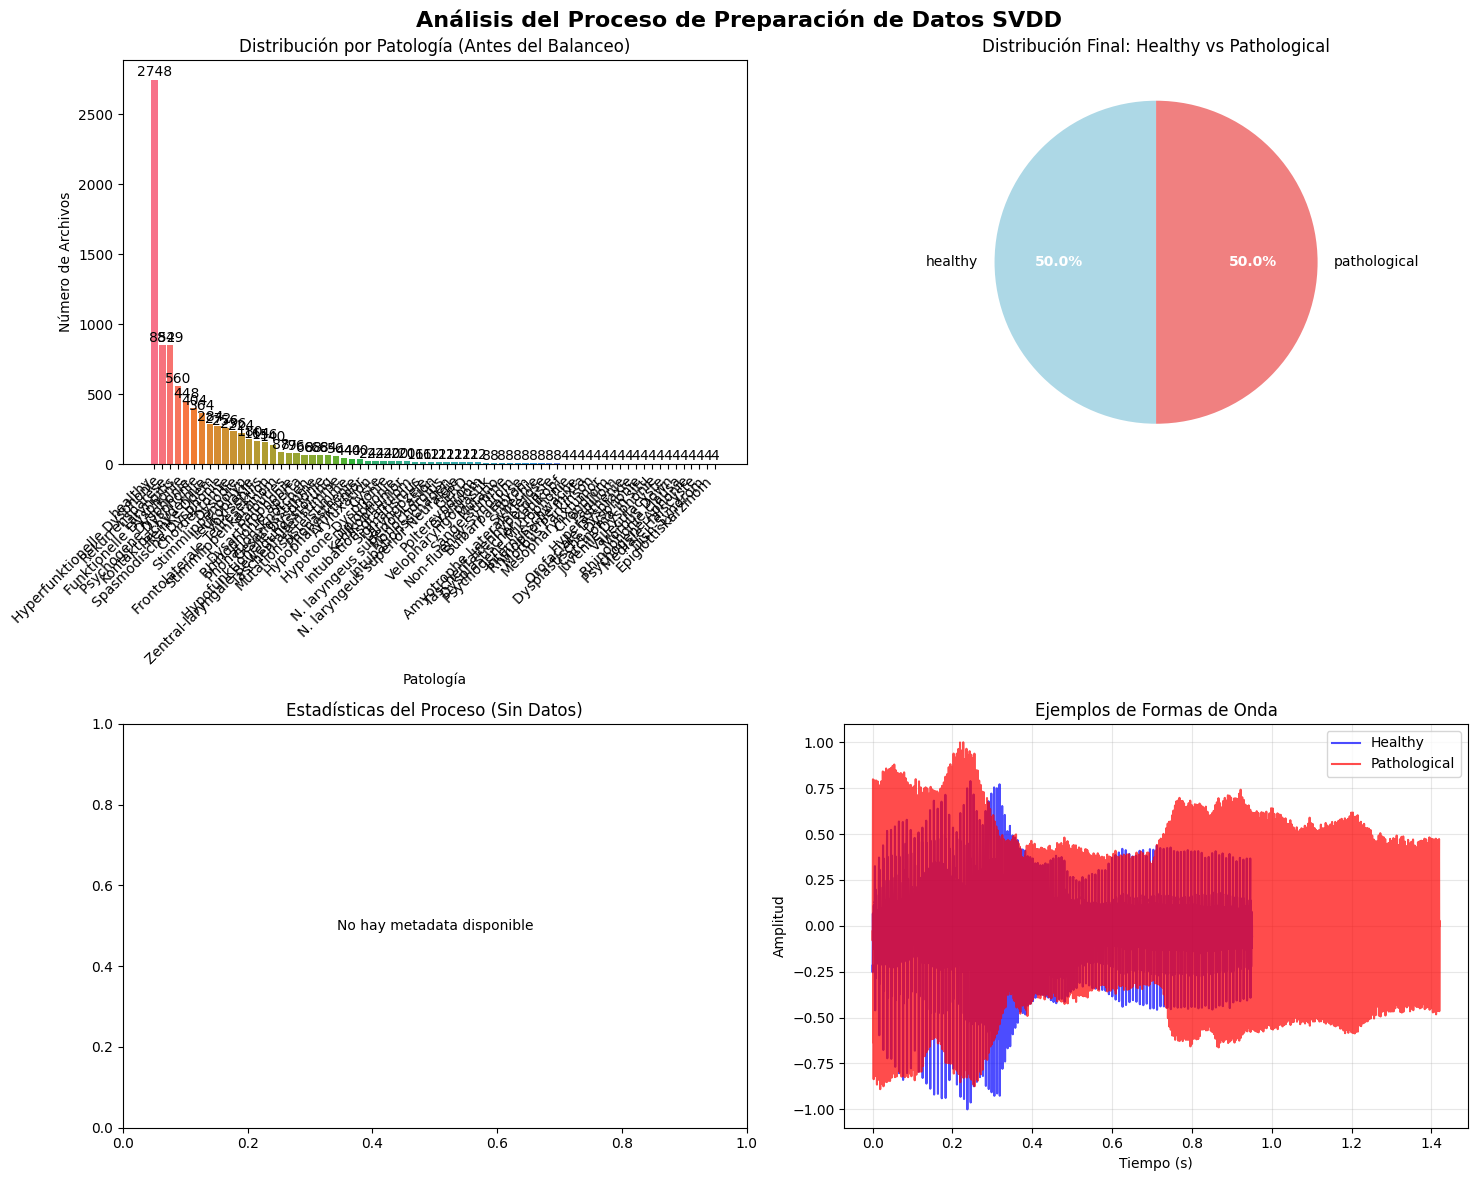


Visualizaciones generadas exitosamente


In [10]:
# ============================================================================
# 7. VISUALIZACIONES Y ANÁLISIS
# ============================================================================

def create_visualizations(extracted_df: pd.DataFrame, balanced_df: pd.DataFrame, final_metadata: Dict):
    """
    Crea visualizaciones del proceso de preparación de datos.
    
    Args:
        extracted_df: DataFrame con archivos extraídos
        balanced_df: DataFrame con archivos balanceados
        final_metadata: Metadata del proceso final
    """
    print(f"[PASO 6/8] Generando visualizaciones...")
    
    # Configurar subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Análisis del Proceso de Preparación de Datos SVDD', fontsize=16, fontweight='bold')
    
    # 1. Gráfico de barras: Distribución por patología (antes del balanceo)
    if not extracted_df.empty:
        pathology_counts = extracted_df['pathology'].value_counts()
        axes[0, 0].bar(range(len(pathology_counts)), pathology_counts.values, 
                      color=sns.color_palette("husl", len(pathology_counts)))
        axes[0, 0].set_title('Distribución por Patología (Antes del Balanceo)')
        axes[0, 0].set_xlabel('Patología')
        axes[0, 0].set_ylabel('Número de Archivos')
        axes[0, 0].set_xticks(range(len(pathology_counts)))
        axes[0, 0].set_xticklabels(pathology_counts.index, rotation=45, ha='right')
        
        # Agregar valores en las barras
        for i, v in enumerate(pathology_counts.values):
            axes[0, 0].text(i, v + 0.5, str(v), ha='center', va='bottom')
    else:
        axes[0, 0].text(0.5, 0.5, 'No hay datos extraídos', ha='center', va='center', transform=axes[0, 0].transAxes)
        axes[0, 0].set_title('Distribución por Patología (Sin Datos)')
    
    # 2. Pie chart: Healthy vs Pathological (después del balanceo)
    if not balanced_df.empty:
        category_counts = balanced_df['category'].value_counts()
        colors = ['lightblue', 'lightcoral']
        wedges, texts, autotexts = axes[0, 1].pie(category_counts.values, 
                                                 labels=category_counts.index,
                                                 colors=colors,
                                                 autopct='%1.1f%%',
                                                 startangle=90)
        axes[0, 1].set_title('Distribución Final: Healthy vs Pathological')
        
        # Mejorar la apariencia del pie chart
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
    else:
        axes[0, 1].text(0.5, 0.5, 'No hay datos balanceados', ha='center', va='center', transform=axes[0, 1].transAxes)
        axes[0, 1].set_title('Distribución Final (Sin Datos)')
    
    # 3. Estadísticas del proceso
    if final_metadata:
        stats_data = [
            ['Archivos NSP extraídos', final_metadata.get('extraction_stats', {}).get('vowel_a_files', 0)],
            ['Conversiones exitosas', final_metadata.get('conversion_stats', {}).get('successful_conversions', 0)],
            ['Archivos balanceados', final_metadata.get('balancing_stats', {}).get('balanced_files', 0)],
            ['Archivos finales', final_metadata.get('final_structure', {}).get('total_files', 0)]
        ]
        
        # Crear tabla
        axes[1, 0].axis('tight')
        axes[1, 0].axis('off')
        table = axes[1, 0].table(cellText=stats_data,
                                colLabels=['Métrica', 'Valor'],
                                cellLoc='center',
                                loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 2)
        axes[1, 0].set_title('Estadísticas del Proceso')
    else:
        axes[1, 0].text(0.5, 0.5, 'No hay metadata disponible', ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Estadísticas del Proceso (Sin Datos)')
    
    # 4. Ejemplo de formas de onda
    if not balanced_df.empty and len(balanced_df) > 0:
        # Seleccionar muestras para visualizar
        healthy_sample = balanced_df[balanced_df['category'] == 'healthy'].iloc[0] if len(balanced_df[balanced_df['category'] == 'healthy']) > 0 else None
        pathological_sample = balanced_df[balanced_df['category'] == 'pathological'].iloc[0] if len(balanced_df[balanced_df['category'] == 'pathological']) > 0 else None
        
        if healthy_sample is not None:
            try:
                # Cargar y mostrar forma de onda healthy
                audio_data, sr = librosa.load(healthy_sample['converted_wav'], sr=None)
                time_axis = np.linspace(0, len(audio_data)/sr, len(audio_data))
                axes[1, 1].plot(time_axis, audio_data, color='blue', alpha=0.7, label='Healthy')
            except:
                pass
        
        if pathological_sample is not None:
            try:
                # Cargar y mostrar forma de onda pathological
                audio_data, sr = librosa.load(pathological_sample['converted_wav'], sr=None)
                time_axis = np.linspace(0, len(audio_data)/sr, len(audio_data))
                axes[1, 1].plot(time_axis, audio_data, color='red', alpha=0.7, label='Pathological')
            except:
                pass
        
        axes[1, 1].set_title('Ejemplos de Formas de Onda')
        axes[1, 1].set_xlabel('Tiempo (s)')
        axes[1, 1].set_ylabel('Amplitud')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'No hay archivos para visualizar', ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Ejemplos de Formas de Onda (Sin Datos)')
    
    plt.tight_layout()
    plt.show()
    
    # Crear tabla resumen
    if final_metadata:
        print(f"\nTABLA RESUMEN DEL PROCESO:")
        print("=" * 60)
        
        summary_data = {
            'Métrica': [
                'Archivos NSP extraídos',
                'Vocales /a/ encontradas', 
                'Archivos healthy extraídos',
                'Archivos pathological extraídos',
                'Conversiones exitosas',
                'Conversiones fallidas',
                'Archivos balanceados',
                'Archivos finales healthy',
                'Archivos finales pathological',
                'Tamaño total (MB)'
            ],
            'Valor': [
                final_metadata.get('extraction_stats', {}).get('total_nsp_files', 0),
                final_metadata.get('extraction_stats', {}).get('vowel_a_files', 0),
                final_metadata.get('extraction_stats', {}).get('healthy_extracted', 0),
                final_metadata.get('extraction_stats', {}).get('pathological_extracted', 0),
                final_metadata.get('conversion_stats', {}).get('successful_conversions', 0),
                final_metadata.get('conversion_stats', {}).get('failed_conversions', 0),
                final_metadata.get('balancing_stats', {}).get('balanced_files', 0),
                final_metadata.get('final_structure', {}).get('healthy_files', 0),
                final_metadata.get('final_structure', {}).get('pathological_files', 0),
                f"{final_metadata.get('final_structure', {}).get('total_size_mb', 0):.1f}"
            ]
        }
        
        summary_df = pd.DataFrame(summary_data)
        print(summary_df.to_string(index=False))
    
    print(f"\nVisualizaciones generadas exitosamente")

# Ejecutar visualizaciones solo si hay datos
if not extracted_df.empty or not balanced_df.empty or final_metadata:
    create_visualizations(extracted_df, balanced_df, final_metadata)
else:
    print("No hay datos suficientes para generar visualizaciones")


In [11]:
# ============================================================================
# 8. VALIDACIÓN FINAL Y REPORTE
# ============================================================================

def validate_final_dataset(output_dir: Path) -> Dict:
    """
    Valida la integridad del dataset final.
    
    Args:
        output_dir: Directorio del dataset final
        
    Returns:
        Diccionario con resultados de validación
    """
    print(f"[PASO 7/8] Validando integridad del dataset final...")
    
    validation_results = {
        'healthy_files': [],
        'pathological_files': [],
        'corrupted_files': [],
        'validation_errors': [],
        'total_validated': 0,
        'total_corrupted': 0
    }
    
    # Validar archivos healthy
    healthy_dir = output_dir / "healthy"
    if healthy_dir.exists():
        for wav_file in healthy_dir.glob("*.wav"):
            try:
                # Intentar cargar el archivo
                audio_data, sr = librosa.load(str(wav_file), sr=None)
                
                # Verificar propiedades básicas
                if len(audio_data) > 0 and sr > 0:
                    validation_results['healthy_files'].append({
                        'filename': wav_file.name,
                        'duration': len(audio_data) / sr,
                        'sample_rate': sr,
                        'channels': 1 if len(audio_data.shape) == 1 else audio_data.shape[1],
                        'valid': True
                    })
                    validation_results['total_validated'] += 1
                else:
                    validation_results['corrupted_files'].append(wav_file.name)
                    validation_results['total_corrupted'] += 1
                    
            except Exception as e:
                validation_results['corrupted_files'].append(wav_file.name)
                validation_results['validation_errors'].append(f"Error en {wav_file.name}: {e}")
                validation_results['total_corrupted'] += 1
    
    # Validar archivos pathological
    pathological_dir = output_dir / "pathological"
    if pathological_dir.exists():
        for wav_file in pathological_dir.glob("*.wav"):
            try:
                # Intentar cargar el archivo
                audio_data, sr = librosa.load(str(wav_file), sr=None)
                
                # Verificar propiedades básicas
                if len(audio_data) > 0 and sr > 0:
                    validation_results['pathological_files'].append({
                        'filename': wav_file.name,
                        'duration': len(audio_data) / sr,
                        'sample_rate': sr,
                        'channels': 1 if len(audio_data.shape) == 1 else audio_data.shape[1],
                        'valid': True
                    })
                    validation_results['total_validated'] += 1
                else:
                    validation_results['corrupted_files'].append(wav_file.name)
                    validation_results['total_corrupted'] += 1
                    
            except Exception as e:
                validation_results['corrupted_files'].append(wav_file.name)
                validation_results['validation_errors'].append(f"Error en {wav_file.name}: {e}")
                validation_results['total_corrupted'] += 1
    
    # Mostrar resultados
    print(f"Validación completada:")
    print(f"   Archivos healthy válidos: {len(validation_results['healthy_files'])}")
    print(f"   Archivos pathological válidos: {len(validation_results['pathological_files'])}")
    print(f"   Total validados: {validation_results['total_validated']}")
    print(f"   Archivos corruptos: {validation_results['total_corrupted']}")
    print(f"   Errores: {len(validation_results['validation_errors'])}")
    
    return validation_results

def generate_final_report(output_dir: Path, final_metadata: Dict, validation_results: Dict):
    """
    Genera reporte final del proceso de preparación.
    
    Args:
        output_dir: Directorio de salida
        final_metadata: Metadata del proceso
        validation_results: Resultados de validación
    """
    print(f"[PASO 8/8] Generando reporte final...")
    
    report_file = output_dir / "preparation_report.txt"
    
    with open(report_file, 'w', encoding='utf-8') as f:
        f.write("=" * 80 + "\n")
        f.write("REPORTE DE PREPARACIÓN DE DATASET SVDD\n")
        f.write("=" * 80 + "\n\n")
        
        # Información general
        f.write("INFORMACIÓN GENERAL:\n")
        f.write("-" * 40 + "\n")
        f.write(f"Fecha de preparación: {final_metadata.get('preparation_info', {}).get('timestamp', 'N/A')}\n")
        f.write(f"ZIP origen: {final_metadata.get('preparation_info', {}).get('source_zip', 'N/A')}\n")
        f.write(f"Patrón vocal: {final_metadata.get('preparation_info', {}).get('vowel_pattern', 'N/A')}\n")
        f.write(f"Sample rate objetivo: {final_metadata.get('preparation_info', {}).get('target_sample_rate', 'N/A')} Hz\n")
        f.write(f"Seed utilizado: {final_metadata.get('preparation_info', {}).get('seed', 'N/A')}\n\n")
        
        # Estadísticas de extracción
        f.write("ESTADÍSTICAS DE EXTRACCIÓN:\n")
        f.write("-" * 40 + "\n")
        extraction_stats = final_metadata.get('extraction_stats', {})
        f.write(f"Total archivos NSP: {extraction_stats.get('total_nsp_files', 0)}\n")
        f.write(f"Vocales /a/ encontradas: {extraction_stats.get('vowel_a_files', 0)}\n")
        f.write(f"Archivos healthy extraídos: {extraction_stats.get('healthy_extracted', 0)}\n")
        f.write(f"Archivos pathological extraídos: {extraction_stats.get('pathological_extracted', 0)}\n\n")
        
        # Estadísticas de conversión
        f.write("ESTADÍSTICAS DE CONVERSIÓN:\n")
        f.write("-" * 40 + "\n")
        conversion_stats = final_metadata.get('conversion_stats', {})
        f.write(f"Total conversiones: {conversion_stats.get('total_conversions', 0)}\n")
        f.write(f"Conversiones exitosas: {conversion_stats.get('successful_conversions', 0)}\n")
        f.write(f"Conversiones fallidas: {conversion_stats.get('failed_conversions', 0)}\n")
        if conversion_stats.get('total_conversions', 0) > 0:
            success_rate = (conversion_stats.get('successful_conversions', 0) / conversion_stats.get('total_conversions', 1)) * 100
            f.write(f"Tasa de éxito: {success_rate:.1f}%\n")
        f.write("\n")
        
        # Estadísticas de balanceo
        f.write("ESTADÍSTICAS DE BALANCEO:\n")
        f.write("-" * 40 + "\n")
        balancing_stats = final_metadata.get('balancing_stats', {})
        f.write(f"Archivos balanceados: {balancing_stats.get('balanced_files', 0)}\n")
        f.write(f"Healthy balanceados: {balancing_stats.get('healthy_balanced', 0)}\n")
        f.write(f"Pathological balanceados: {balancing_stats.get('pathological_balanced', 0)}\n\n")
        
        # Estructura final
        f.write("ESTRUCTURA FINAL:\n")
        f.write("-" * 40 + "\n")
        final_structure = final_metadata.get('final_structure', {})
        f.write(f"Total archivos finales: {final_structure.get('total_files', 0)}\n")
        f.write(f"Archivos healthy finales: {final_structure.get('healthy_files', 0)}\n")
        f.write(f"Archivos pathological finales: {final_structure.get('pathological_files', 0)}\n")
        f.write(f"Tamaño total: {final_structure.get('total_size_mb', 0):.1f} MB\n")
        f.write(f"Errores en organización: {final_structure.get('errors', 0)}\n\n")
        
        # Validación
        f.write("VALIDACIÓN FINAL:\n")
        f.write("-" * 40 + "\n")
        f.write(f"Archivos healthy válidos: {len(validation_results.get('healthy_files', []))}\n")
        f.write(f"Archivos pathological válidos: {len(validation_results.get('pathological_files', []))}\n")
        f.write(f"Total validados: {validation_results.get('total_validated', 0)}\n")
        f.write(f"Archivos corruptos: {validation_results.get('total_corrupted', 0)}\n")
        f.write(f"Errores de validación: {len(validation_results.get('validation_errors', []))}\n\n")
        
        # Errores detallados
        if validation_results.get('validation_errors'):
            f.write("ERRORES DE VALIDACIÓN:\n")
            f.write("-" * 40 + "\n")
            for error in validation_results['validation_errors']:
                f.write(f"- {error}\n")
            f.write("\n")
        
        # Archivos corruptos
        if validation_results.get('corrupted_files'):
            f.write("ARCHIVOS CORRUPTOS:\n")
            f.write("-" * 40 + "\n")
            for corrupted_file in validation_results['corrupted_files']:
                f.write(f"- {corrupted_file}\n")
            f.write("\n")
        
        f.write("=" * 80 + "\n")
        f.write("FIN DEL REPORTE\n")
        f.write("=" * 80 + "\n")
    
    print(f"Reporte guardado en: {report_file}")

# Ejecutar validación y reporte final solo si no está completado
if not check_step_completed('validation'):
    # Asegurar que el directorio de salida existe
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    
    if OUTPUT_DIR.exists():
        print(f"\nIniciando validación final...")
        validation_results = validate_final_dataset(OUTPUT_DIR)
        
        if final_metadata:
            print(f"\nGenerando reporte final...")
            generate_final_report(OUTPUT_DIR, final_metadata, validation_results)
            print(f"Reporte generado exitosamente")
            
            # Guardar estado final
            save_state('validation')
        else:
            print(f"No hay metadata para generar reporte")
            validation_results = {}
    else:
        print(f"No se pudo crear el directorio de salida: {OUTPUT_DIR}")
        validation_results = {}
else:
    print("Validación ya completada. Saltando paso...")
    validation_results = {}


Estado previo encontrado: balancing

Iniciando validación final...
[PASO 7/8] Validando integridad del dataset final...
Validación completada:
   Archivos healthy válidos: 2748
   Archivos pathological válidos: 5412
   Total validados: 8160
   Archivos corruptos: 0
   Errores: 0
No hay metadata para generar reporte


In [12]:
# ============================================================================
# 9. LIMPIEZA Y RESUMEN FINAL
# ============================================================================

def cleanup_temp_files(temp_dir: Path):
    """
    Limpia archivos temporales.
    
    Args:
        temp_dir: Directorio temporal a limpiar
    """
    print(f"Limpiando archivos temporales...")
    
    try:
        if temp_dir.exists():
            shutil.rmtree(temp_dir)
            print(f"Directorio temporal eliminado: {temp_dir}")
        else:
            print(f"Directorio temporal no existe: {temp_dir}")
    except Exception as e:
        print(f"Error limpiando directorio temporal: {e}")

def count_final_files():
    """
    Cuenta archivos en las carpetas finales.
    
    Returns:
        Diccionario con conteos de archivos
    """
    counts = {
        'healthy_files': 0,
        'pathological_files': 0,
        'total_files': 0,
        'healthy_size_mb': 0,
        'pathological_size_mb': 0,
        'total_size_mb': 0
    }
    
    # Contar archivos healthy
    if HEALTHY_DIR.exists():
        healthy_files = list(HEALTHY_DIR.glob("*.wav"))
        counts['healthy_files'] = len(healthy_files)
        counts['healthy_size_mb'] = sum(f.stat().st_size for f in healthy_files) / (1024*1024)
    
    # Contar archivos pathological
    if PATHOLOGICAL_DIR.exists():
        pathological_files = list(PATHOLOGICAL_DIR.glob("*.wav"))
        counts['pathological_files'] = len(pathological_files)
        counts['pathological_size_mb'] = sum(f.stat().st_size for f in pathological_files) / (1024*1024)
    
    counts['total_files'] = counts['healthy_files'] + counts['pathological_files']
    counts['total_size_mb'] = counts['healthy_size_mb'] + counts['pathological_size_mb']
    
    return counts

def print_final_summary(final_metadata: Dict, validation_results: Dict):
    """
    Imprime resumen final del proceso.
    
    Args:
        final_metadata: Metadata del proceso
        validation_results: Resultados de validación
    """
    print("\n" + "="*80)
    print("RESUMEN FINAL DEL PROCESO DE PREPARACIÓN SVDD")
    print("="*80)
    
    # Contar archivos actuales en las carpetas
    current_counts = count_final_files()
    
    if final_metadata:
        # Información general
        print(f"\nINFORMACIÓN GENERAL:")
        print(f"   Fecha: {final_metadata.get('preparation_info', {}).get('timestamp', 'N/A')}")
        print(f"   ZIP origen: {final_metadata.get('preparation_info', {}).get('source_zip', 'N/A')}")
        print(f"   Patrón vocal: {final_metadata.get('preparation_info', {}).get('vowel_pattern', 'N/A')}")
        print(f"   Sample rate: {final_metadata.get('preparation_info', {}).get('target_sample_rate', 'N/A')} Hz")
        
        # Estadísticas finales
        final_structure = final_metadata.get('final_structure', {})
        print(f"\nESTRUCTURA FINAL:")
        print(f"   Total archivos: {final_structure.get('total_files', 0)}")
        print(f"   Healthy: {final_structure.get('healthy_files', 0)}")
        print(f"   Pathological: {final_structure.get('pathological_files', 0)}")
        print(f"   Tamaño total: {final_structure.get('total_size_mb', 0):.1f} MB")
        
        # Validación
        print(f"\nVALIDACIÓN:")
        print(f"   Archivos válidos: {validation_results.get('total_validated', 0)}")
        print(f"   Archivos corruptos: {validation_results.get('total_corrupted', 0)}")
        print(f"   Errores: {len(validation_results.get('validation_errors', []))}")
        
        # Tasa de éxito general
        total_processed = final_metadata.get('extraction_stats', {}).get('vowel_a_files', 0)
        final_files = final_structure.get('total_files', 0)
        if total_processed > 0:
            success_rate = (final_files / total_processed) * 100
            print(f"\nTASA DE ÉXITO GENERAL: {success_rate:.1f}%")
            print(f"   ({final_files} archivos finales de {total_processed} extraídos)")
    
    # Mostrar conteo actual de archivos
    print(f"\nARCHIVOS EN CARPETAS FINALES:")
    print(f"   {HEALTHY_DIR}: {current_counts['healthy_files']} archivos ({current_counts['healthy_size_mb']:.1f} MB)")
    print(f"   {PATHOLOGICAL_DIR}: {current_counts['pathological_files']} archivos ({current_counts['pathological_size_mb']:.1f} MB)")
    print(f"   Total: {current_counts['total_files']} archivos ({current_counts['total_size_mb']:.1f} MB)")
    
    print(f"\nARCHIVOS GENERADOS:")
    print(f"   Dataset: {OUTPUT_DIR}/")
    print(f"   Metadata: {OUTPUT_DIR}/metadata.json")
    print(f"   Reporte: {OUTPUT_DIR}/preparation_report.txt")
    
    print(f"\nPRÓXIMOS PASOS:")
    print(f"   1. Verificar que los archivos WAV se cargan correctamente")
    print(f"   2. Usar el dataset en el pipeline de entrenamiento")
    print(f"   3. Ejecutar data_preprocessing.ipynb con los nuevos datos")
    
    print("\n" + "="*80)
    print("PROCESO COMPLETADO EXITOSAMENTE")
    print("="*80)

# Ejecutar limpieza y resumen final
print(f"\nFinalizando proceso...")

# Mostrar estado actual de las carpetas
print(f"\nESTADO ACTUAL DE LAS CARPETAS:")
print(f"   Directorio principal: {OUTPUT_DIR}")
print(f"   Existe: {OUTPUT_DIR.exists()}")

if OUTPUT_DIR.exists():
    print(f"   Contenido:")
    for item in OUTPUT_DIR.iterdir():
        if item.is_dir():
            file_count = len(list(item.glob("*.wav")))
            size_mb = sum(f.stat().st_size for f in item.glob("*.wav")) / (1024*1024)
            print(f"     {item.name}/: {file_count} archivos WAV ({size_mb:.1f} MB)")
        else:
            print(f"     {item.name}")

# Limpiar archivos temporales solo si el proceso está completo
if check_step_completed('validation'):
    cleanup_temp_files(TEMP_DIR)
    print("Proceso completado. Archivos temporales eliminados.")
else:
    print("Proceso no completado. Conservando archivos temporales para continuar después.")

# Mostrar resumen final
print_final_summary(final_metadata, validation_results)

print(f"\nNotebook de preparación de datos SVDD completado.")
print(f"El dataset está listo para ser usado en el pipeline de entrenamiento.")



Finalizando proceso...

ESTADO ACTUAL DE LAS CARPETAS:
   Directorio principal: data\svdd_processed
   Existe: True
   Contenido:
     healthy/: 2748 archivos WAV (272.7 MB)
     pathological/: 5412 archivos WAV (527.0 MB)
Estado previo encontrado: balancing
Proceso no completado. Conservando archivos temporales para continuar después.

RESUMEN FINAL DEL PROCESO DE PREPARACIÓN SVDD

ARCHIVOS EN CARPETAS FINALES:
   data\svdd_processed\healthy: 2748 archivos (272.7 MB)
   data\svdd_processed\pathological: 5412 archivos (527.0 MB)
   Total: 8160 archivos (799.7 MB)

ARCHIVOS GENERADOS:
   Dataset: data\svdd_processed/
   Metadata: data\svdd_processed/metadata.json
   Reporte: data\svdd_processed/preparation_report.txt

PRÓXIMOS PASOS:
   1. Verificar que los archivos WAV se cargan correctamente
   2. Usar el dataset en el pipeline de entrenamiento
   3. Ejecutar data_preprocessing.ipynb con los nuevos datos

PROCESO COMPLETADO EXITOSAMENTE

Notebook de preparación de datos SVDD completa